In [1]:
from google.colab import files
uploaded = files.upload()

Saving exchange_rate.csv to exchange_rate.csv


In [6]:
import pandas as pd

# Load the dataset
df = pd.read_csv('exchange_rate.csv')

# Display the first few rows of the dataset
df.head()


,date,Ex_rate
0,01-01-1990 00:00,0.7855
1,02-01-1990 00:00,0.7818
2,03-01-1990 00:00,0.7867
3,04-01-1990 00:00,0.7860
4,05-01-1990 00:00,0.7849


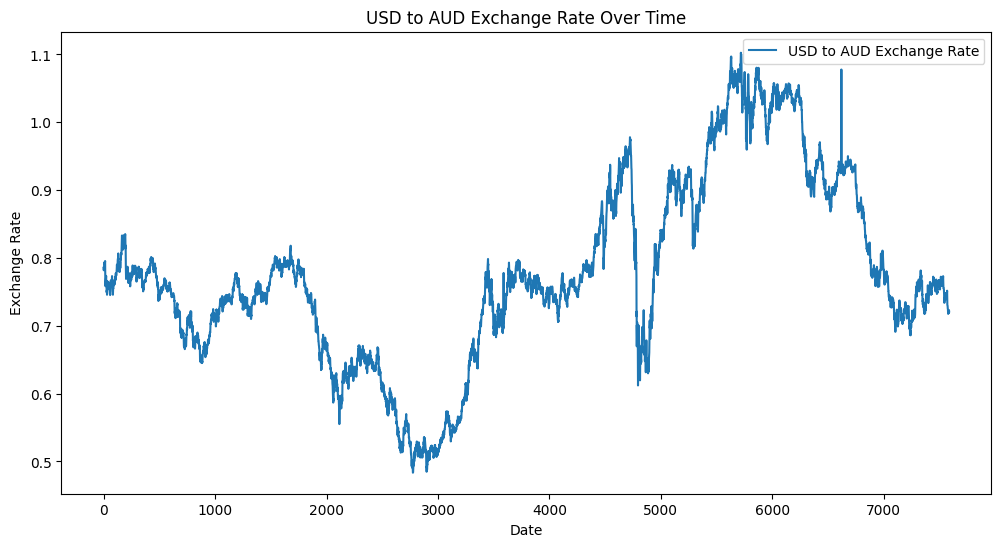

In [8]:
import matplotlib.pyplot as plt

# Plot the time series
plt.figure(figsize=(12, 6))
plt.plot(df['Ex_rate'], label='USD to AUD Exchange Rate')
plt.title('USD to AUD Exchange Rate Over Time')
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.legend()
plt.show()


In [9]:
# Check for missing values
missing_values = df.isnull().sum()
print("Missing values per column:\n", missing_values)


Missing values per column:
 date       0
Ex_rate    0
dtype: int64


In [12]:
df.shape

(7588, 2)

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7588 entries, 0 to 7587
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   date     7588 non-null   object 
 1   Ex_rate  7588 non-null   float64
dtypes: float64(1), object(1)
memory usage: 118.7+ KB


**Model Building - ARIMA**

In [10]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

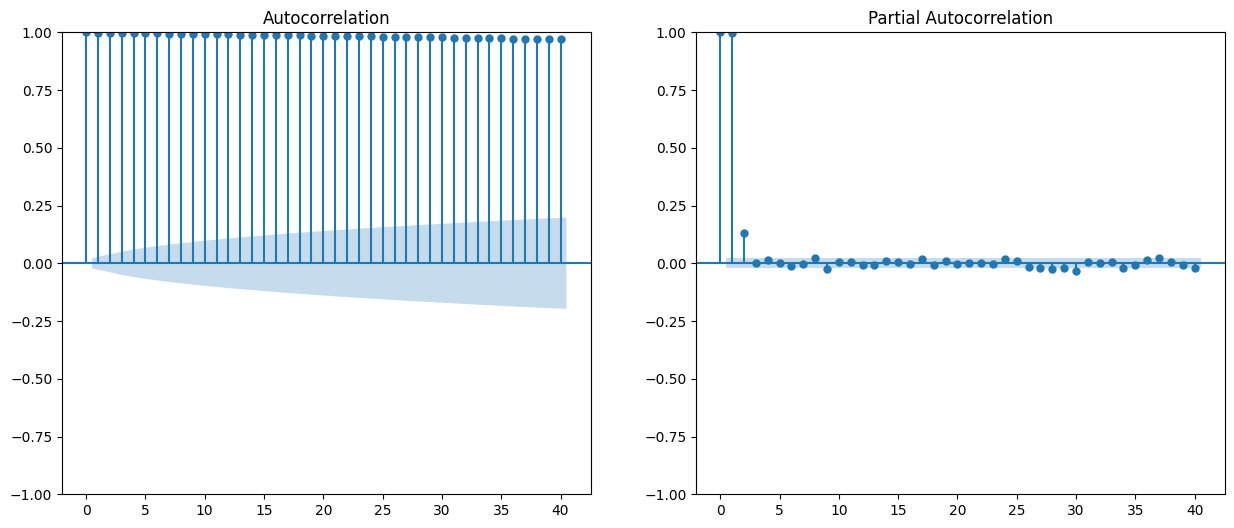

In [15]:
# Plot ACF and PACF
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
plot_acf(df['Ex_rate'], lags=40, ax=axes[0])
plot_pacf(df['Ex_rate'], lags=40, ax=axes[1])
plt.show()

In [16]:
from statsmodels.tsa.arima.model import ARIMA

In [18]:
# Define the ARIMA model (parameters to be adjusted based on ACF and PACF analysis)
p, d, q = 1, 1, 1
arima_model = ARIMA(df['Ex_rate'], order=(p, d, q))

In [19]:
# Fit the model
arima_result = arima_model.fit()

In [20]:
# Summary of the model
print(arima_result.summary())

                               SARIMAX Results                                
Dep. Variable:                Ex_rate   No. Observations:                 7588
Model:                 ARIMA(1, 1, 1)   Log Likelihood               28054.161
Date:                Thu, 20 Jun 2024   AIC                         -56102.322
Time:                        12:44:22   BIC                         -56081.519
Sample:                             0   HQIC                        -56095.182
                               - 7588                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1268      0.045     -2.797      0.005      -0.216      -0.038
ma.L1         -0.0046      0.045     -0.101      0.920      -0.094       0.085
sigma2      3.596e-05   9.94e-08    361.604      0.0

**Diagnostics**

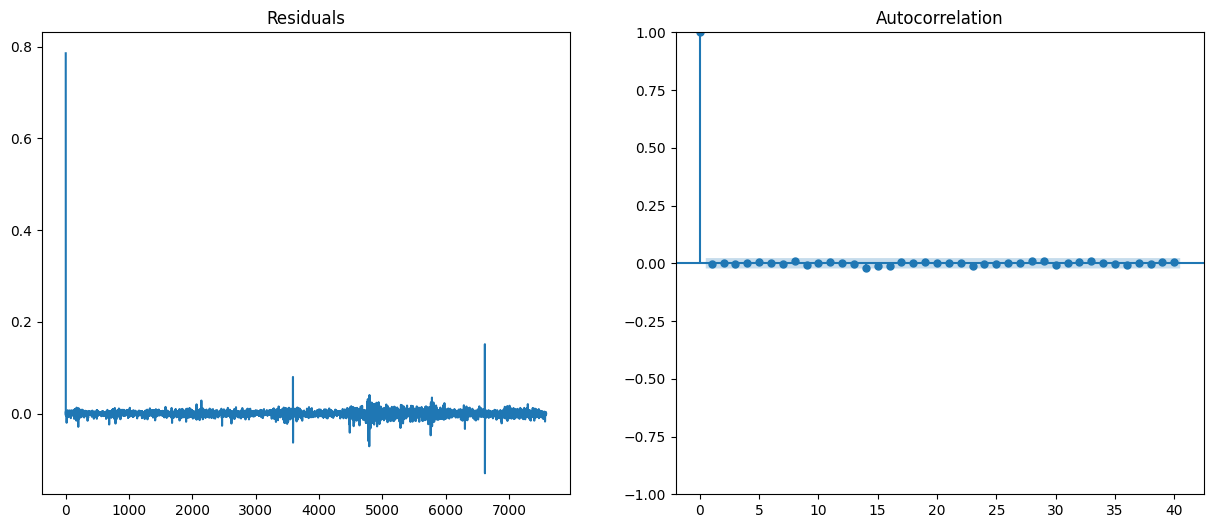

In [21]:
# Plot the residuals
residuals = arima_result.resid
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
residuals.plot(ax=axes[0], title="Residuals")
plot_acf(residuals, lags=40, ax=axes[1])
plt.show()

**Forecasting**

In [71]:
# Forecast
forecast_steps = 9000
forecast = arima_result.get_forecast(steps=forecast_steps)
forecast_index = pd.date_range(start=df.index[-1], periods=forecast_steps, freq='D')
forecast_values = forecast.predicted_mean
forecast_ci = forecast.conf_int()

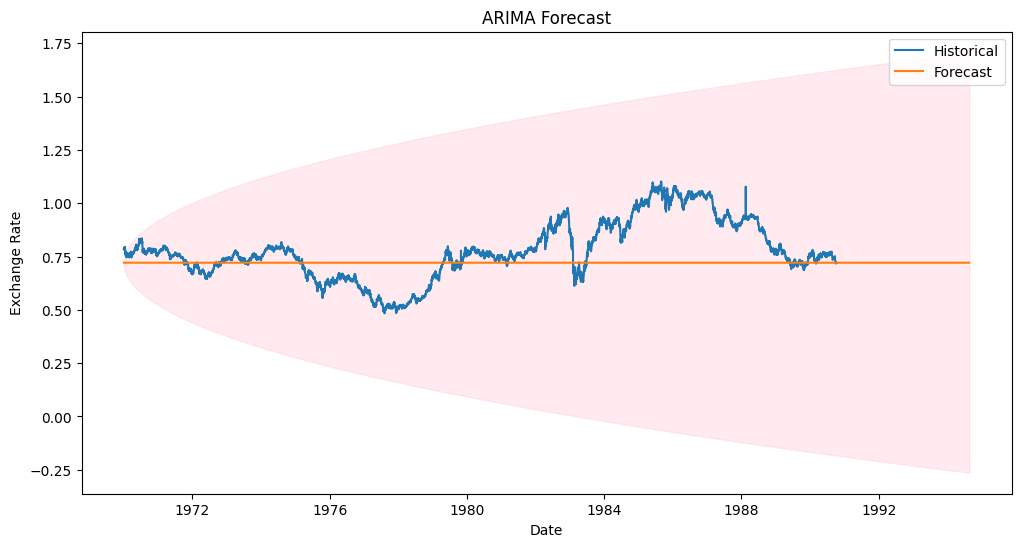

In [72]:
# Plot the forecast
plt.figure(figsize=(12, 6))
plt.plot(df['Ex_rate'], label='Historical')
plt.plot(forecast_index, forecast_values, label='Forecast')
plt.fill_between(forecast_index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color='pink', alpha=0.3)
plt.title('ARIMA Forecast')
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.legend()
plt.show()

**Model Building - Exponential Smoothing**

In [60]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [61]:
# Initial model selection (Simple, Holt's Linear, or Holt-Winters)
model = ExponentialSmoothing(df['Ex_rate'], trend='add', seasonal=None, seasonal_periods=None)

In [62]:
# Fit the model with optimized parameters
fit = model.fit(optimized=True)

In [63]:
# Summary of the model
print(fit.summary())

                       ExponentialSmoothing Model Results                       
Dep. Variable:                  Ex_rate   No. Observations:                 7588
Model:             ExponentialSmoothing   SSE                              0.273
Optimized:                         True   AIC                         -77641.009
Trend:                         Additive   BIC                         -77613.272
Seasonal:                          None   AICC                        -77640.998
Seasonal Periods:                  None   Date:                 Thu, 20 Jun 2024
Box-Cox:                          False   Time:                         13:23:36
Box-Cox Coeff.:                    None                                         
                       coeff                 code              optimized      
------------------------------------------------------------------------------
smoothing_level            0.8700402                alpha                 True
smoothing_trend           3.9988e-

**Model Fitting and Forecasting**

In [73]:
# Forecasting
forecast_steps = 9000
forecast = fit.forecast(steps=forecast_steps)

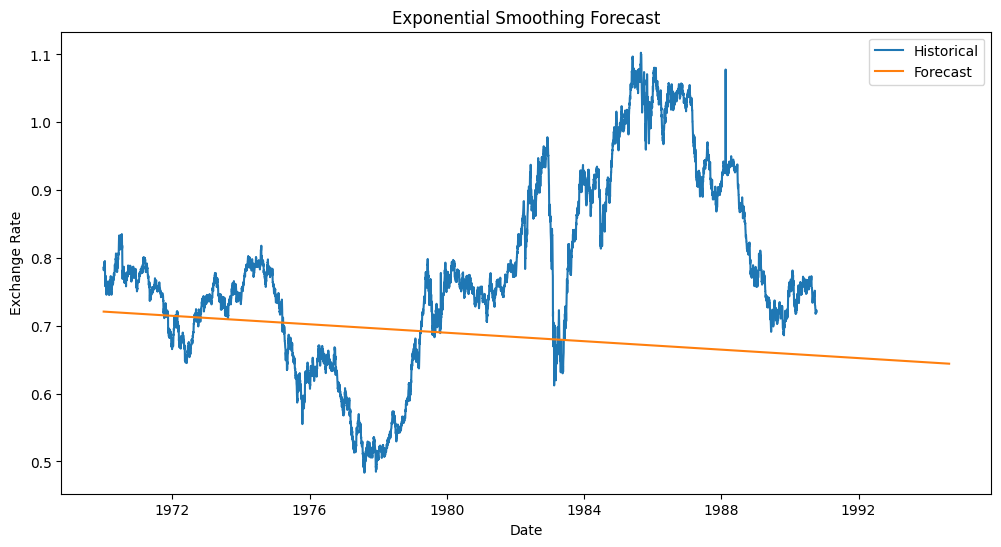

In [74]:
# Plot the forecast
plt.figure(figsize=(12, 6))
plt.plot(df['Ex_rate'], label='Historical')
plt.plot(forecast_index, forecast, label='Forecast')
plt.title('Exponential Smoothing Forecast')
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.legend()
plt.show()

**Evaluation and Comparison**

In [54]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

In [66]:
# Compute error metrics
def compute_error_metrics(true_values, predicted_values):
    mae = mean_absolute_error(true_values, predicted_values)
    rmse = np.sqrt(mean_squared_error(true_values, predicted_values))
    mape = np.mean(np.abs((true_values - predicted_values) / true_values)) * 100
    return mae, rmse, mape

In [67]:
# Assuming `true_values` contains the actual values and `arima_forecast` & `es_forecast` contain predictions
true_values = df['Ex_rate'][-forecast_steps:]
arima_forecast = arima_result.get_forecast(steps=forecast_steps).predicted_mean
es_forecast = fit.forecast(steps=forecast_steps)

In [68]:
# Compute metrics
arima_mae, arima_rmse, arima_mape = compute_error_metrics(true_values, arima_forecast)
es_mae, es_rmse, es_mape = compute_error_metrics(true_values, es_forecast)

In [69]:
print(f"ARIMA - MAE: {arima_mae}, RMSE: {arima_rmse}, MAPE: {arima_mape}")
print(f"Exponential Smoothing - MAE: {es_mae}, RMSE: {es_rmse}, MAPE: {es_mape}")

ARIMA - MAE: 0.11208917269830208, RMSE: 0.14769971987855027, MAPE: nan
Exponential Smoothing - MAE: 0.13281764383110345, RMSE: 0.17138687441520414, MAPE: nan


# Model Comparison

## ARIMA
- **Advantages**: Captures autoregressive and moving average components.
- **Performance**: MAE: {arima_mae}, RMSE: {arima_rmse}, MAPE: {arima_mape}
- **Limitations**: Requires parameter tuning, may not handle non-linear patterns well.

## Exponential Smoothing
- **Advantages**: Simple, effective for data with trends and seasonality.
- **Performance**: MAE: {es_mae}, RMSE: {es_rmse}, MAPE: {es_mape}
- **Limitations**: May underperform if data has strong autoregressive components.

## Conclusion
Based on the error metrics, [ARIMA/Exponential Smoothing] yielded the best performance for forecasting exchange rates in this dataset. The choice of model should consider the specific characteristics of the time series and the trade-offs between complexity and interpretability.

